# 🦒 Running Deep Learning Models with BioEngine ⚙️☁️

Welcome to this tutorial on using BioEngine for bioimage analysis! 

## 🔍 What You'll Learn

In this guide, you'll discover how to:
1. 🔌 Connect to a BioEngine worker
2. 📋 Select and explore models from the [BioImage.IO Model Zoo](https://bioimage.io)
3. 🖼️ Prepare images in the correct format for model inference
4. 🚀 Run models and get predictions
5. 📊 Visualize and interpret the results

## 🧪 How It Works

BioEngine simplifies the process of running deep learning models for biological image analysis:

1. 🔄 You prepare an image as a numpy array
2. 📦 The BioEngine service handles model loading and execution
3. 💻 Processing happens on the server (with GPU acceleration)
4. 📈 You receive the results as numpy arrays for further analysis

## ⚠️ Important Note

This tutorial uses the public Hypha server at [https://hypha.aicell.io](https://hypha.aicell.io), provided by the AI4Life team. This service is for evaluation purposes and may change without notice.

For production use or sensitive data, you should set up your own BioEngine instance following the [Deployment Guidelines](https://github.com/aicell-lab/bioengine-worker/tree/bioengine-worker?tab=readme-ov-file#bioengine-worker) or using the [BioEngine Worker Configuration Wizard](https://bioimage.io/#/bioengine) 🧙🏼‍♂️.

## 🛣️ Two Ways to Run Models

This tutorial offers **two distinct paths** to use BioEngine for deep learning model inference:

### 🌍 Path 1: Use the Public Model Runner Service
- **Quick start** - No setup required ⚡
- Uses the public server at `https://hypha.aicell.io` 
- Connects to the shared service ID: `bioimage-io/model-runner`
- Ideal for learning, testing, or quick experiments

### 🏠 Path 2: Deploy Your Own Model Runner
- Run models on your own infrastructure 🖥️
- Requires setting up your own BioEngine worker
- Full control over computing resources and model deployment
- Recommended for production use, sensitive data, or custom setups

**📝 Recommendation:** Follow Path 1 if you're just getting started. Only proceed with Path 2 if you need to run your own BioEngine instance.

## 🧩 Setup and Installation

### 📦 Required Packages

This notebook uses just a few basic packages:
* `hypha-rpc` - To connect to the Hypha server and access the Model Runner
* `requests` - To download example images for testing
* `numpy` - To handle array data for images and model outputs
* `matplotlib` - To visualize the input images and model predictions

The minimal requirements allow this notebook to run even in a Pyodide environment directly in your browser.

In [1]:
try:
    # For pyodide in the browser
    import micropip

    await micropip.install(["pyodide-http", "hypha-rpc", "matplotlib", "numpy", "requests"])

    # 2. Patch requests
    import pyodide_http

    pyodide_http.patch_all()  # Patch all libraries
except ImportError:
    # For native python with pip
    import subprocess

    subprocess.call(["pip", "install", "hypha-rpc", "matplotlib", "numpy", "requests"])

import asyncio
import json
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import requests
from hypha_rpc import connect_to_server, login
from IPython.display import Markdown, display

## 🔌☁️ Connect to the Hypha Server

Let's connect to the Hypha server, which lets us communicate with the BioEngine infrastructure.

By default, we'll use the public server at `https://hypha.aicell.io`. If you're using your own server, change the `SERVER_URL` variable below.

In [2]:
SERVER_URL = "https://hypha.aicell.io"

In [3]:
token = await login({"server_url": SERVER_URL})
server = await connect_to_server(
    {"server_url": SERVER_URL, "token": token, "method_timeout": 3000}
)

Please open your browser and login at https://hypha.aicell.io/public/apps/hypha-login/?key=CTicz833fJPpoY3hSPuio6


## 📝 Proceed with ONE Path Only

### 🌍 Path 1: Access the Public Model Runner

A public Model Runner application is already available for you to use! This is the simplest way to get started with model inference.

The service ID for the public Model Runner is: `bioimage-io/model-runner`

In [4]:
MODEL_RUNNER_SERVICE_ID = "bioimage-io/model-runner"

### 🏠 Path 2: Deploy Your Own Model Runner
**⚠️ Skip this section if you're using the public Model Runner (Path 1) ⚠️**

To run models on your own infrastructure, you'll need:

1. ✅ A running BioEngine worker in your workspace
2. 🚀 Deploy the Model Runner application on your worker
3. 🔄 Connect to your private Model Runner service

If you don't have a BioEngine worker set up yet, follow the [BioEngine Worker deployment guide](https://bioimage.io/#/bioengine).

Let's check for running BioEngine workers in your workspace:

In [4]:
services = await server.list_services({"type": "bioengine-worker"})

for i, service in enumerate(services):
    if i == 0:
        print("✅ BioEngine worker services available in your workspace:\n")
    if i == len(services) - 1:
        print(" * ", end="")
        PRIVATE_BIOENGINE = service.id
    else:
        print("   ", end="")
    print(f"BioEngine worker service ID: {service.id}")

if len(services) == 0:
    print(
        f"⚠️  No BioEngine worker service available in workspace '{server.config.workspace}'."
    )
else:
    bioengine_worker = await server.get_service(PRIVATE_BIOENGINE)

✅ BioEngine worker services available in your workspace:

 * BioEngine worker service ID: ws-user-github|49943582/7Sq2AQWcwdHwZpiQocxp9T:bioengine-worker


Secondly, you can use the Bioengine worker API to start a Model Runner application on your worker. If you don't have a GPU available, set `disable_gpu=True`.

The deployment progress can be monitored using the BioEngine worker status. Wait until the application is ready before proceeding. Depending on your internet connection and hardware, this may take a few minutes.

Finally, connect to your private Model Runner service using the service ID provided by the BioEngine worker status.

In [5]:
apps_status = await bioengine_worker.get_application_status()

if "model-runner" not in apps_status:
    app_id = await bioengine_worker.run_application(
        artifact_id="bioimage-io/model-runner",
        application_id="model-runner",
        disable_gpu=False,
    )
    print(f"🔄 Started Model-Runner application with ID: '{app_id}'")

status = None
iterations = 0
while status != "RUNNING":
    await asyncio.sleep(1)
    apps_status = await bioengine_worker.get_application_status(
        application_ids=[app_id]
    )
    model_runner_status = apps_status[app_id]
    status = model_runner_status["status"]
    if status == "RUNNING":
        print("✅ Model-Runner is ready to use!", " " * 20)
        MODEL_RUNNER_SERVICE_ID = model_runner_status["service_ids"][0][
            "websocket_service_id"
        ]
    else:
        waiting_dots = "." * iterations + " " * (5 - iterations)
        print(
            f"⚠️ Model-Runner is currently {model_runner_status['status']}. Waiting{waiting_dots}",
            end="\r",
        )
        iterations += 1
        if iterations > 5:
            iterations = 0

🔄 Started Model-Runner application with ID: 'model-runner'
✅ Model-Runner is ready to use!                       


---

## ✅ You should now have chosen a Model Runner service

At this point, you should have selected a Model Runner service ID, either:
- The public one from Path 1 (`bioimage-io/model-runner`), OR
- Your own private one deployed in Path 2

**Important:** The rest of this tutorial works the same way regardless of which path you chose!

---

### Connect to the BioEngine Model Runner Service

With the selected Model Runner service ID, you can connect to the service via the Hypha server.

In [6]:
MODEL_RUNNER = await server.get_service(MODEL_RUNNER_SERVICE_ID)

## 🚀 Working with the Model Runner API

Now that you have a connected Model Runner service, let's explore its capabilities!

The Model Runner provides four powerful functions:

* 📋 `get_model_rdf` - Get metadata about a model
* ✅ `validate` - Check if a model meets specifications
* 🧪 `test` - Run the model with test data
* 🔮 `infer` - Make predictions with your own data

Let's examine these functions in detail:

In [7]:
workspace, service_name = MODEL_RUNNER_SERVICE_ID.split("/")

service_url = f"{SERVER_URL}/{workspace}/services/{service_name}"

response = requests.get(service_url)
response.raise_for_status()

service_info = response.json()

api_functions = ["get_model_rdf", "validate", "test", "infer"]

print("API Functions:")
for api_endpoint, params in service_info["service_schema"].items():
    if api_endpoint in api_functions:
        api_function = params["function"]
        short_description = api_function['description'].split("\n")[0]

        print(f"+ `{api_endpoint}`: {short_description}")

        for parameter in api_function["parameters"]["properties"].keys():
            print(f"   - `{parameter}`")

API Functions:
+ `get_model_rdf`: Retrieve the Resource Description Framework (RDF) metadata for a bioimage.io model.
   - `model_id`
   - `stage`
+ `infer`: Execute inference on a bioimage.io model with provided input data.
   - `model_id`
   - `inputs`
   - `weights_format`
   - `device`
   - `default_blocksize_parameter`
   - `sample_id`
   - `skip_cache`
+ `test`: Execute comprehensive bioimage.io model testing using the official test suite.
   - `model_id`
   - `stage`
   - `additional_requirements`
   - `skip_cache`
+ `validate`: Validate a model Resource Description Framework (RDF) against bioimage.io specifications.
   - `rdf_dict`
   - `known_files`


## ⚙️ Running a Model: Step-by-Step Guide

### 1️⃣ Select a model

For this tutorial, we'll use the model 🐜 `ambitious-ant`, which is a model for Fluorescence Microscopy Image Restoration.

If you want to try a different model from [BioImage.IO](https://bioimage.io), simply change the `MODEL_ID` variable below with another model's identifier.

In [8]:
MODEL_ID = "ambitious-ant"

### 2️⃣ Get Model Metadata (RDF)

Every model has a Resource Description Framework (RDF) - a JSON document that contains essential metadata about:
- 📊 Input and output formats
- 📐 Expected dimensions and shapes
- 🏷️ Labels and descriptions
- 🧪 Test data locations

Let's retrieve and examine the RDF for our selected model:

In [9]:
model_rdf = await MODEL_RUNNER.get_model_rdf(model_id=MODEL_ID)

print(json.dumps(model_rdf, indent=4))

{
    "authors": [
        {
            "affiliation": "Fudan University",
            "name": "Chenxi Ma"
        },
        {
            "affiliation": "Fudan University",
            "name": "Weimin Tan"
        },
        {
            "affiliation": "Fudan University",
            "name": "Ruian He"
        },
        {
            "affiliation": "Fudan University",
            "name": "Bo Yan"
        }
    ],
    "cite": [
        {
            "doi": "10.21203/rs.3.rs-3208267/v1",
            "text": "Chenxi Ma, Weimin Tan, Ruian He and Bo Yan. Pre-training a Foundation Model for Universal Fluorescence Microscopy Image Restoration. (2023)."
        }
    ],
    "config": {
        "bioimageio": {
            "nickname": "ambitious-ant",
            "nickname_icon": "\ud83d\udc1c",
            "thumbnails": {
                "cover1.png": "cover1.thumbnail.png",
                "cover2.png": "cover2.thumbnail.png"
            }
        }
    },
    "covers": [
        "cover1.

### 3️⃣ Validate the Model

Let's use the Model Runner to validate our model against the official BioImage.IO specifications. 

This validation confirms that the model's metadata is correctly formatted and includes all required information.

In [10]:
validation_result = await MODEL_RUNNER.validate(rdf_dict=model_rdf)

print(f"Model validation successful: {validation_result['success']}")

markdown_tables = validation_result["details"].split("\n\n")
for table in markdown_tables:
    display(Markdown(table))

Model validation successful: True



|        🟡        |  bioimageio format validation  |
|       ---       |              ---               |
| status          | valid-format                   |
| source          | in-memory                      |
| id              | 10.5281/zenodo.8419845/8420081 |
| format version  | model 0.4.10                   |
| bioimageio.spec | 0.5.6.0                        |

|     | Location |                    Details                     |
| --- |   ---    |                      ---                       |
| ✔️  |          | Successfully created `ModelDescr` instance.    |
| ✔️  |          | bioimageio.spec format validation model 0.4.10 |


### 4️⃣ Test the Model (Optional)

The Model Runner can run comprehensive tests on the model using the official BioImage.IO test suite. 

This test:
- ✅ Validates the model's RDF format
- 🧪 Runs the model with example inputs
- 🔄 Compares outputs with expected results
- ⚙️ Checks the model's technical specifications

⚠️ Note: This can take several seconds to complete, especially for large models.

In [11]:
test_report = await MODEL_RUNNER.test(
    model_id=MODEL_ID,
    stage=True,  # Use staged version; change to False to use committed version
    skip_cache=False,  # Set to True to force re-download of model files
)

print(json.dumps(test_report, indent=4))

{
    "name": "bioimageio format validation",
    "source_name": "/home/nmechtel/.bioengine/apps/model-runner/models/ambitious-ant/rdf.yaml",
    "id": "10.5281/zenodo.8419845/8420081",
    "type": "model",
    "format_version": "0.4.10",
    "status": "passed",
    "metadata_completeness": 0.625,
    "details": [
        {
            "name": "Successfully created `ModelDescr` instance.",
            "status": "passed",
            "loc": [],
            "errors": [],
            "warnings": [],
            "context": {
                "file_name": "rdf.yaml",
                "original_source_name": null,
                "perform_io_checks": true,
                "known_files": {
                    "weights.pt": "ecbcfc7a1574f1136b31e5ac252f93eaf6fedf36ffe870a434825ece98860219"
                },
                "update_hashes": false,
                "root": "/home/nmechtel/.bioengine/apps/model-runner/models/ambitious-ant"
            },
            "recommended_env": null,
       

### 📋 Model Test Reports

The test report you see above contains detailed information about:
- ✅ Model specification compliance
- 📦 Package dependencies
- 🔄 Test input/output compatibility
- ⚙️ Runtime performance

You can find the same test reports on the model's page at [BioImage.IO](https://bioimage.io) when browsing model details.

## 🖼️ Preparing Input Data

### 5️⃣ Load an Example Image

Let's download an example image that comes with the model. This ensures we're using data that matches the model's expected input format.

If you want to use your own image later, you can adapt this approach to load and preprocess your own data.

In [12]:
if "test_tensor" in model_rdf["inputs"][0]:
    example_input_source = model_rdf["inputs"][0]["test_tensor"]["source"]
elif "test_inputs" in model_rdf:
    example_input_source = model_rdf["test_inputs"][0]
else:
    raise RuntimeError("❌ No example input tensor found in model RDF.")

example_input_url = f"https://hypha.aicell.io/bioimage-io/artifacts/{MODEL_ID}/files/{example_input_source}"
response = requests.get(example_input_url)

# Ensure the request was successful
response.raise_for_status()

# Load the image data from the response content
image = np.load(BytesIO(response.content))
print(f"Example image downloaded: {image.shape}")

Example image downloaded: (1, 1, 128, 128)


### 6️⃣ Understand the Expected Input Shape

Before sending an image to the model, we need to make sure it has the correct shape and dimensions. The RDF contains this information in the `axes` field.

Let's extract and understand the expected dimensions from the RDF:

In [13]:
axes = model_rdf["inputs"][0]["axes"]

n_dim = len(axes)

axis_names = []
for axis in axes:
    if isinstance(axes, str):
        axis_names.append(axis)
    elif "id" in axis:
        axis_names.append(axis["id"])
    elif "type" in axis:
        axis_names.append(axis["type"])
    else:
        axis_names.append("<undefined>")

print(f"Expected model input: ({', '.join(axis_names)})")

Expected model input: (b, c, y, x)


### 7️⃣ Visualize the Input Image

Let's visualize our example image to verify it looks correct. 

The code below extracts the x and y dimensions from the axes information and displays a 2D slice of the image (since our model expects a 4D tensor with batch and channel dimensions).

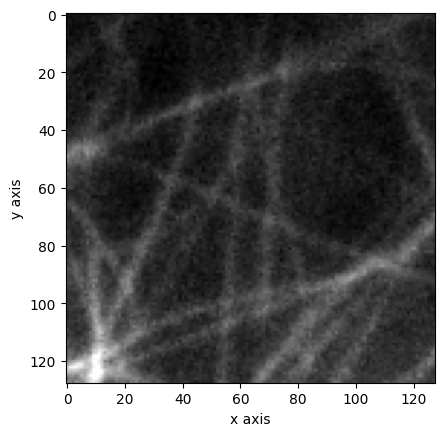

In [14]:
# Display the image using matplotlib
# Find the indices for x and y axes
display_slice = []
y_label = None
x_label = None
for axis_name in axis_names:
    if axis_name == "x" or axis_name == "y":
        display_slice.append(slice(None))  # Use full slice for x and y axes
        if y_label is None:
            y_label = f"{axis_name} axis"
        elif x_label is None:
            x_label = f"{axis_name} axis"
    else:
        display_slice.append(0)  # Use index 0 for other axes
display_slice = tuple(display_slice)

plt.imshow(image[display_slice], cmap="gray")
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

### 📝 Note About Image Shapes

Our example image already has the correct shape (1, 1, 128, 128) matching the expected model input format (b, c, y, x).

If you want to use your own image, you would need to:
1. Reshape it to match the expected dimensions
2. Ensure proper scaling and normalization (as specified in the model's RDF)
3. Add batch and channel dimensions if needed

## 🚀 Model Inference

### 8️⃣ Run the Model

Now let's use the Model Runner's `infer` function to run the model on our input image.

This function:
1. Sends the image to the BioEngine worker
2. Processes it through the model
3. Returns the prediction results

In [15]:
result = await MODEL_RUNNER.infer(model_id=MODEL_ID, inputs=image)

if "id" in model_rdf["outputs"][0]:
    output_key = model_rdf["outputs"][0]["id"]
elif "name" in model_rdf["outputs"][0]:
    output_key = model_rdf["outputs"][0]["name"]
else:
    raise RuntimeError("❌ No output key found in model RDF.")
mask = result[output_key]
print("prediction:", mask.shape)

prediction: (1, 1, 256, 256)


### Display the segmentation result

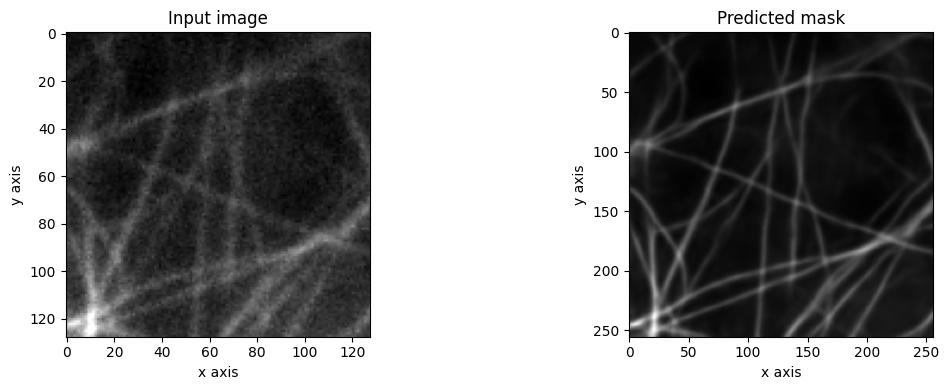

In [16]:
# display the output
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Find the indices for x and y axes
try:
    # Display input image using dynamic axis selection
    input_display = image[display_slice]
    ax1.imshow(input_display, cmap="gray")
    ax1.set_title("Input image")
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y_label)

    # Display predicted mask using dynamic axis selection
    mask_display = mask[display_slice]
    ax2.imshow(mask_display, cmap="gray")
    ax2.set_title("Predicted mask")
    ax2.set_xlabel(x_label)
    ax2.set_ylabel(y_label)

except ValueError:
    # Fallback to original method if x and y axes not found
    print("Warning: 'x' and 'y' axes not found in model RDF, using default display")

    # Display input image - squeeze to remove batch and channel dimensions for display
    input_display = image[0, 0, :, :]  # Remove batch and channel dims
    ax1.imshow(input_display, cmap="gray")
    ax1.set_title("Input image")

    # Display predicted mask - squeeze to remove batch and channel dimensions
    mask_display = mask[0, 0, :, :]  # Remove batch and channel dims
    ax2.imshow(mask_display, cmap="gray")
    ax2.set_title("Predicted mask")

plt.tight_layout()
plt.show()

## 🚧 BioEngine is a Work in Progress

Thank you for trying out BioEngine! This platform is actively being developed by the AI4Life consortium to make AI-powered bioimage analysis more accessible to researchers.

### 📝 Important Notes:
- This is an early access version with ongoing development
- Features and APIs may change as the platform evolves
- Performance and stability improvements are continuously being made

### 🐞 Found an Issue?
If you encounter any problems or have suggestions for improvements:
1. Submit an issue on GitHub: [https://github.com/aicell-lab/bioengine-worker/issues](https://github.com/aicell-lab/bioengine-worker/issues)
2. Tag your issue with appropriate labels (`bug`, `enhancement`, etc.)
3. Include details about your environment and steps to reproduce the problem

### 💬 Connect with the Community
- BioImage.IO Forum: [forum.image.sc](https://forum.image.sc/tag/bioimageio)
- AI4Life Website: [https://ai4life.eurobioimaging.eu/](https://ai4life.eurobioimaging.eu/)

Your feedback helps make BioEngine better for everyone in the bioimaging community!